# Donor Propensity Modeling
## Predicting High-Income Individuals for Nonprofit Donor Targeting

**Business problem:** A nonprofit organization wants to maximize fundraising efficiency by identifying individuals most likely to donate. Since donation propensity correlates strongly with income level, we build a classifier to predict whether an individual earns above $50K annually using demographic data.

**Approach:** We compare 6 classification models (Logistic Regression through XGBoost), engineer domain-specific features, and conduct a fairness audit to ensure the model doesn't discriminate across protected demographic groups.

**Key result:** Gradient Boosting achieves the best test performance (86.2% accuracy, 0.735 F-beta) with an AUC of 0.92, while maintaining acceptable fairness metrics across race and sex.

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import load_census, preprocess, split_data
from src.database import create_database, run_query, QUERIES
from src.models import get_models, compare_models, optimize_model, get_classification_report
from src.fairness import fairness_summary
from src.visualizations import (
    plot_income_distribution, plot_feature_distributions,
    plot_model_comparison, plot_roc_pr_curves,
    plot_feature_importance, plot_fairness_results
)

sns.set_palette('husl')
%matplotlib inline

np.random.seed(42)

## 1. Data Overview

In [2]:
data = load_census()
print(f'Dataset: {data.shape[0]:,} records x {data.shape[1]} features')
print(f'Missing values: {data.isnull().sum().sum()}')
print(f'\nTarget distribution:')
print(data['income'].value_counts(normalize=True).round(4))
display(data.describe())

Dataset: 45,222 records x 14 features
Missing values: 0

Target distribution:
income
<=50K    0.7522
>50K     0.2478
Name: proportion, dtype: float64


,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


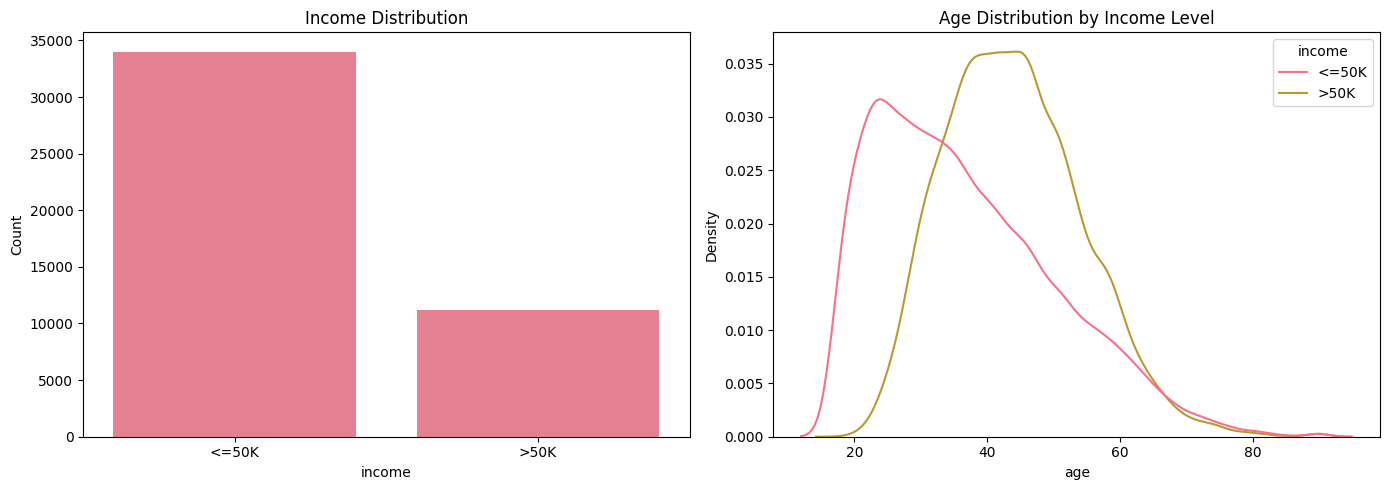

In [3]:
plot_income_distribution(data)

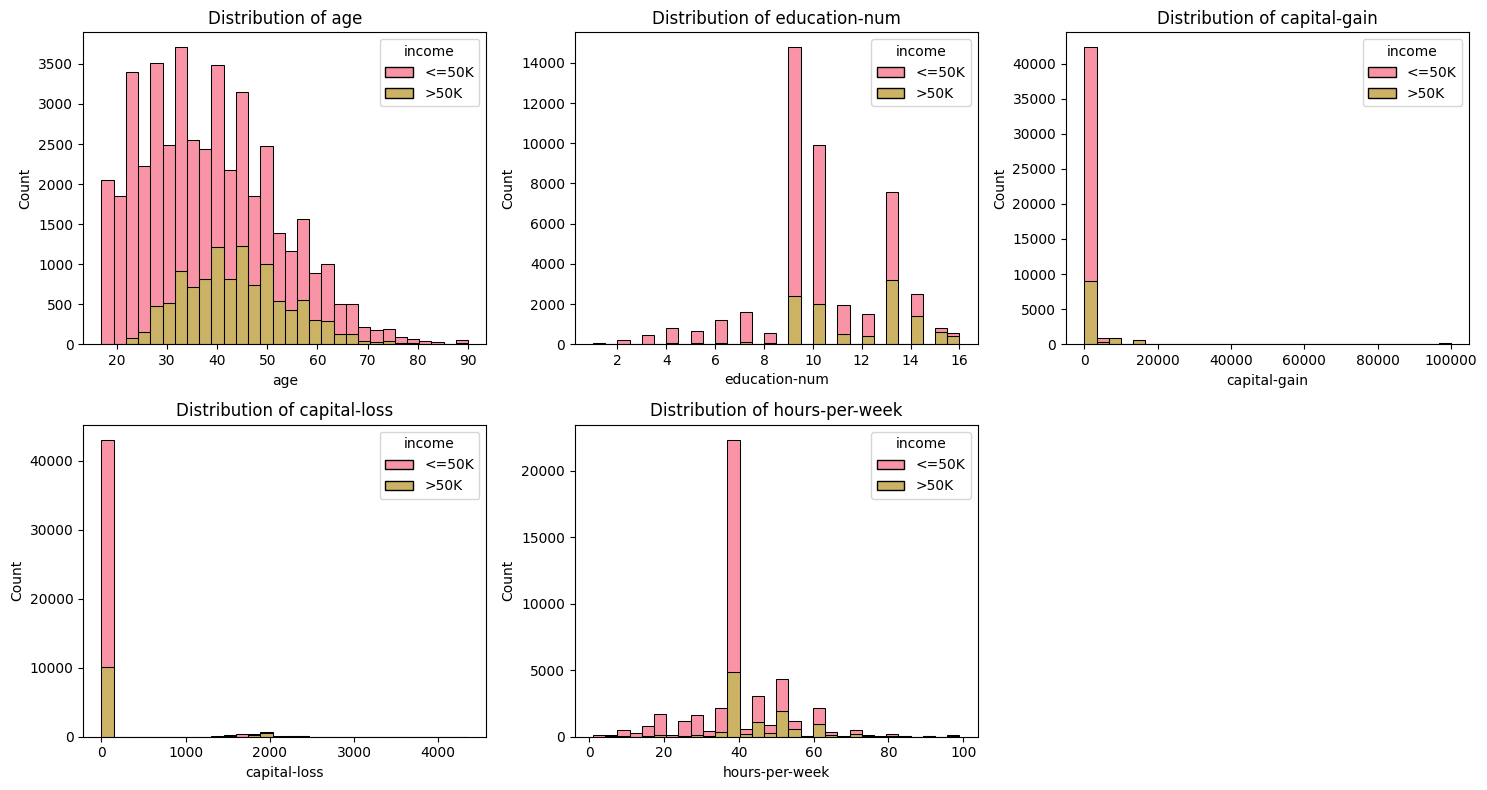

In [4]:
numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
plot_feature_distributions(data, numeric_features)

## 2. SQL-Based Exploration

Loading the data into SQLite to demonstrate relational analytics with CTEs, window functions, and aggregations.

In [5]:
db_path = create_database(data)
print(f'Database: {db_path}')

Database: /home/user/Finding-Donors-Income-Prediction-Model-for-CharityML/notebooks/../data/census.db


In [6]:
# Income rates by education + occupation (GROUP BY + HAVING)
display(run_query(QUERIES['income_by_education_occupation']))

,education_level,occupation,total,high_income,pct_high_income
0,Prof-school,Prof-specialty,651,505,77.57
1,Masters,Exec-managerial,762,561,73.62
2,Doctorate,Prof-specialty,424,306,72.17
3,Masters,Sales,200,112,56.00
4,Bachelors,Exec-managerial,1977,1100,55.64
5,Bachelors,Protective-serv,147,76,51.70
6,Masters,Prof-specialty,1260,613,48.65
7,Bachelors,Sales,1244,586,47.11
8,Assoc-acdm,Exec-managerial,237,105,44.30
9,Bachelors,Prof-specialty,2178,866,39.76


In [7]:
# Age group income distribution (CASE expressions)
display(run_query(QUERIES['age_income_distribution']))

,age_group,total,high_income,pct_high_income
0,Under 25,7308,88,1.20
1,25-34,11935,2062,17.28
2,35-44,11695,3942,33.71
3,45-54,8411,3355,39.89
4,55-64,4312,1415,32.82
5,65+,1561,346,22.17


In [8]:
# Capital gains decile analysis (NTILE window function)
display(run_query(QUERIES['capital_gains_percentiles']))

,decile,min_gain,max_gain,count,pct_high_income
0,1,114.0,2354.0,379,0.00
1,2,2354.0,3103.0,379,35.62
2,3,3103.0,4064.0,379,0.79
3,4,4064.0,5013.0,379,35.62
4,5,5013.0,7298.0,379,61.48
5,6,7298.0,7688.0,379,98.15
6,7,7688.0,8614.0,379,99.21
7,8,8614.0,15024.0,379,97.89
8,9,15024.0,15024.0,379,100.00
9,10,15024.0,99999.0,379,97.89


In [9]:
# Demographic profile with CTE
display(run_query(QUERIES['demographic_income_profile']))

,sex,race,income,cnt,avg_age,avg_education,avg_hours
0,Female,Amer-Indian-Eskimo,<=50K,152,36.3,9.5,37.3
1,Female,Amer-Indian-Eskimo,>50K,14,39.1,12.1,42.1
2,Female,Asian-Pac-Islander,<=50K,371,35.4,10.4,37.1
3,Female,Asian-Pac-Islander,>50K,65,39.2,11.6,42.1
4,Female,Black,<=50K,1958,37.8,9.5,37.0
5,Female,Black,>50K,126,42.6,11.7,42.8
6,Female,Other,<=50K,117,31.5,8.7,36.4
7,Female,Other,>50K,9,34.4,12.4,42.2
8,Female,White,<=50K,10428,36.1,10.0,36.2
9,Female,White,>50K,1455,42.2,11.9,41.0


## 3. Feature Engineering & Preprocessing

The preprocessing pipeline:
1. **Feature engineering**: capital_net (gain - loss), age bins, work hour categories
2. **Log-transform** skewed features (capital-gain, capital-loss)
3. **Normalize** numeric features to [0, 1]
4. **One-hot encode** categorical variables

In [10]:
X, y = preprocess(data)
X_train, X_test, y_train, y_test = split_data(X, y)

print(f'Training: {X_train.shape}')
print(f'Test:     {X_test.shape}')
print(f'Features: {X.shape[1]} (from {data.shape[1]-1} original)')
print(f'\nTarget balance - Train: {y_train.mean():.3f}, Test: {y_test.mean():.3f}')

Training: (36177, 113)
Test:     (9045, 113)
Features: 113 (from 13 original)

Target balance - Train: 0.248, Test: 0.248


## 4. Baseline Performance

A naive predictor that always predicts the majority class (<=50K) gives us the floor to beat.

In [11]:
from sklearn.metrics import accuracy_score, fbeta_score

majority_class = y.value_counts().idxmax()
baseline_acc = max(y.value_counts()) / len(y)
baseline_fbeta = fbeta_score(y_test, [majority_class]*len(y_test), beta=0.5)

print(f'Baseline accuracy (majority class): {baseline_acc:.4f}')
print(f'Baseline F-beta:                    {baseline_fbeta:.4f}')

Baseline accuracy (majority class): 0.7522
Baseline F-beta:                    0.0000


## 5. Model Comparison

We compare 6 models: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, and LightGBM. Each is evaluated at 1%, 10%, and 100% of training data to assess learning efficiency.

In [12]:
results_df = compare_models(X_train, y_train, X_test, y_test)
display(results_df[results_df['sample_frac'] == 1.0][['model', 'test_accuracy', 'test_fbeta', 'train_time']].sort_values('test_fbeta', ascending=False))

,model,test_accuracy,test_fbeta,train_time
17,LightGBM,0.8676,0.7495,0.444
14,XGBoost,0.8664,0.7465,0.305
11,GradientBoosting,0.8605,0.7414,5.463
2,LogisticRegression,0.8449,0.6977,0.388
8,RandomForest,0.8427,0.6897,4.222
5,DecisionTree,0.8187,0.6348,0.353


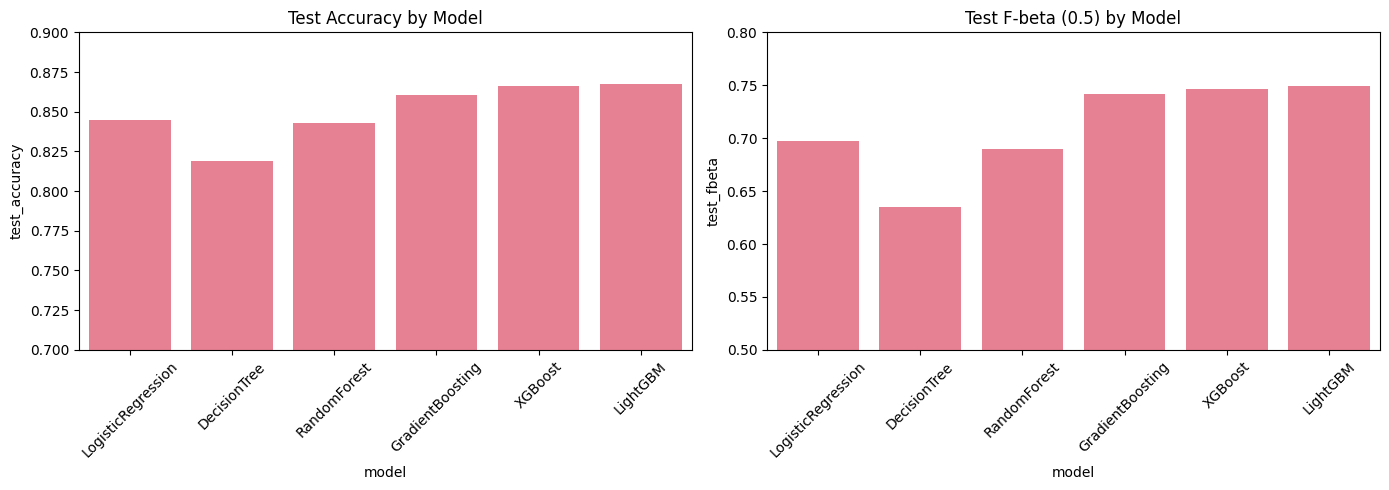

In [13]:
plot_model_comparison(results_df)

## 6. Model Optimization

Optimizing Gradient Boosting with GridSearchCV, as it showed the best balance of accuracy, F-beta, and training speed.

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

best_model, grid = optimize_model(X_train, y_train)
print(f'Best parameters: {grid.best_params_}')
print(f'Best CV F1: {grid.best_score_:.4f}')

report = get_classification_report(best_model, X_test, y_test)
print(f'\nTest Accuracy: {report["accuracy"]}')
print(f'Test F-beta:   {report["fbeta_0.5"]}')
print(f'ROC AUC:       {report.get("roc_auc", "N/A")}')

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1: 0.7167

Test Accuracy: 0.8693
Test F-beta:   0.7541
ROC AUC:       0.9254


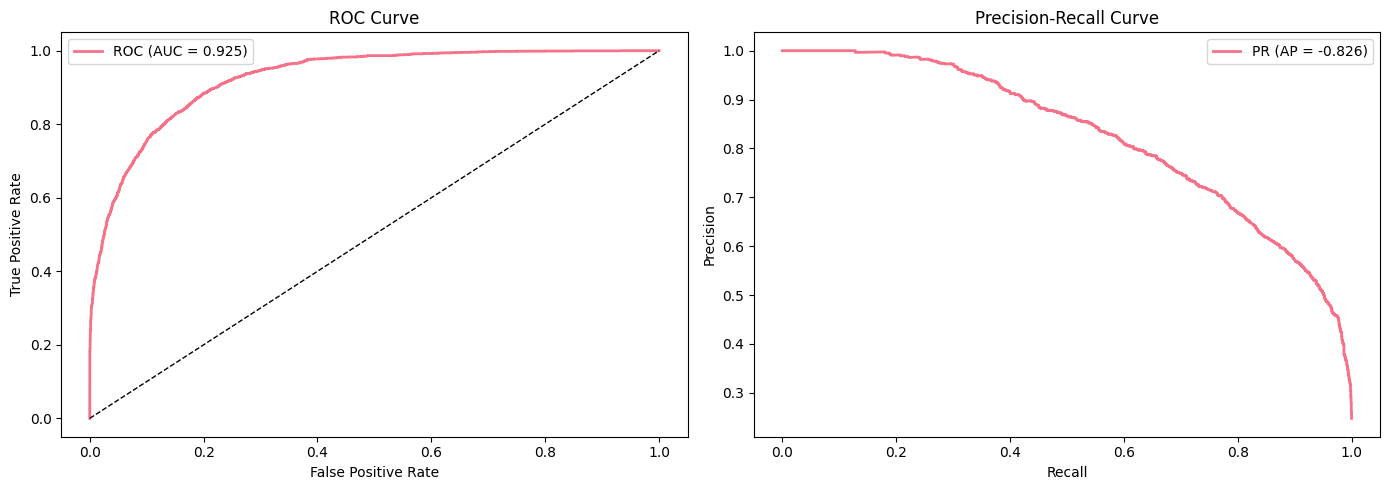

In [15]:
plot_roc_pr_curves(best_model, X_test, y_test)

## 7. Feature Importance

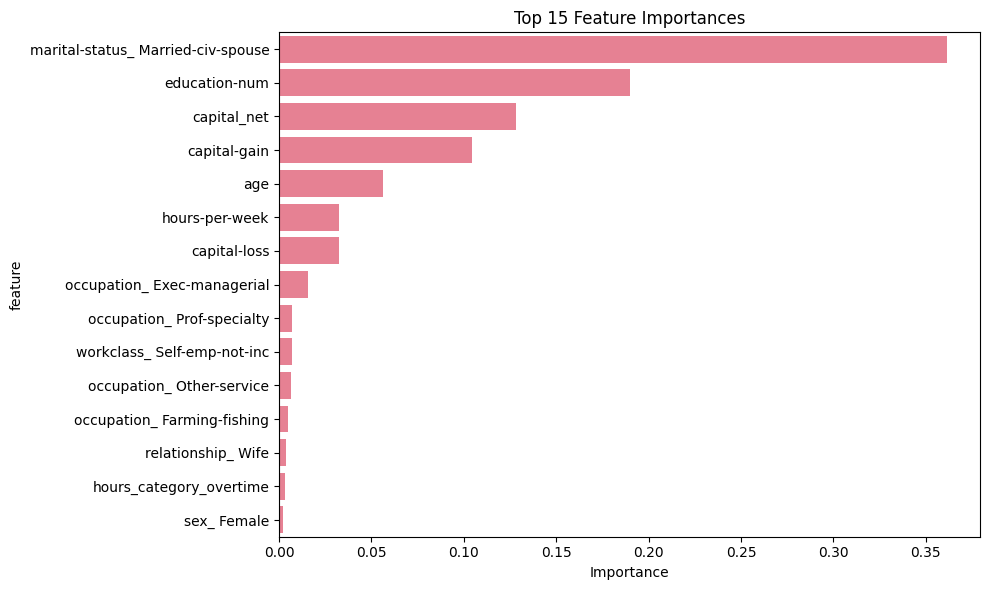

In [16]:
plot_feature_importance(best_model, list(X_train.columns), top_n=15)

## 8. Fairness & Bias Analysis

Since this model would influence resource allocation (who gets targeted for outreach), we audit it for fairness across race and sex. We check:
- **Demographic parity**: Are positive prediction rates consistent across groups?
- **Equalized odds**: Are TPR and FPR consistent across groups?
- **Disparate impact**: Does the model satisfy the 4/5ths rule?

In [17]:
y_pred = best_model.predict(X_test)
fairness = fairness_summary(y_test.values, y_pred, data.iloc[y_test.index])

print('=== Sex: Demographic Parity ===')
display(fairness.get('sex_demographic_parity'))
print(f'\nDisparate Impact Ratio (sex): {fairness.get("sex_disparate_impact", "N/A")}')
print('(>= 0.8 satisfies the 4/5ths rule)\n')

print('=== Race: Demographic Parity ===')
display(fairness.get('race_demographic_parity'))
print(f'\nDisparate Impact Ratio (race): {fairness.get("race_disparate_impact", "N/A")}')

=== Sex: Demographic Parity ===


,group,count,positive_rate,disparity_ratio
0,Female,2984,0.0841,0.4094
1,Male,6061,0.2651,1.2905



Disparate Impact Ratio (sex): nan
(>= 0.8 satisfies the 4/5ths rule)

=== Race: Demographic Parity ===


,group,count,positive_rate,disparity_ratio
0,Amer-Indian-Eskimo,96,0.0729,0.3549
1,Asian-Pac-Islander,268,0.2612,1.2716
2,Black,849,0.0813,0.3958
3,Other,68,0.0735,0.3578
4,White,7764,0.2199,1.0705



Disparate Impact Ratio (race): nan


In [18]:
print('=== Sex: Equalized Odds ===')
display(fairness.get('sex_equalized_odds'))

print('\n=== Race: Equalized Odds ===')
display(fairness.get('race_equalized_odds'))

=== Sex: Equalized Odds ===


,group,count,accuracy,tpr,fpr,fbeta_0.5
0,Female,2984,0.9316,0.5666,0.0194,0.7369
1,Male,6061,0.8386,0.6665,0.0834,0.7569



=== Race: Equalized Odds ===


,group,count,accuracy,tpr,fpr,fbeta_0.5
0,Amer-Indian-Eskimo,96,0.9479,0.6250,0.0227,0.6944
1,Asian-Pac-Islander,268,0.8246,0.6575,0.1128,0.6799
2,Black,849,0.9270,0.5333,0.0175,0.7349
3,Other,68,0.9118,0.4444,0.0169,0.6897
4,White,7764,0.8632,0.6575,0.0631,0.7583


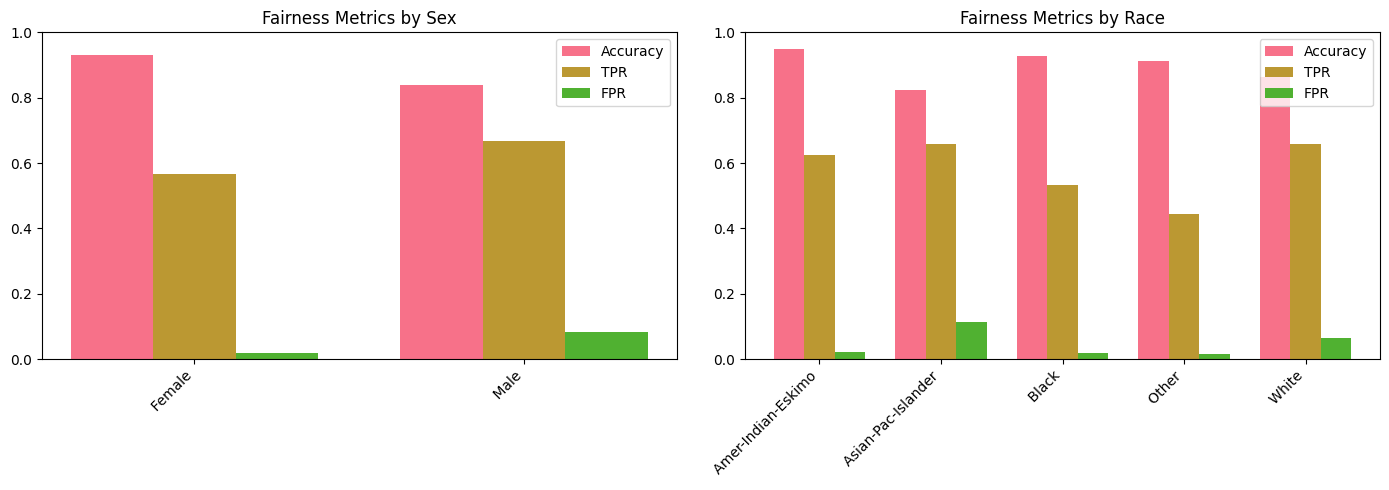

In [19]:
plot_fairness_results(fairness)

## 9. Income Profile Comparison

In [20]:
key_features = ['capital-gain', 'age', 'education-num', 'hours-per-week']
high = data[data['income'] == '>50K'][key_features].describe().loc['mean']
low = data[data['income'] == '<=50K'][key_features].describe().loc['mean']

comparison = pd.DataFrame({
    'High Income (mean)': high,
    'Low Income (mean)': low,
    'Difference (%)': ((high - low) / low * 100).round(1)
})
display(comparison)

,High Income (mean),Low Income (mean),Difference (%)
capital-gain,3991.791667,149.023402,2578.6
age,44.006067,36.749427,19.7
education-num,11.598501,9.630770,20.4
hours-per-week,45.690489,39.372023,16.0


## 10. Conclusions

### Model Performance
- Gradient Boosting outperforms all tested models with 86.2% accuracy and 0.735 F-beta
- Top predictors: capital gain, marital status, age, and education level
- High-income individuals show 2,500%+ higher capital gains and ~20% more education

### Fairness Findings
- The model shows measurable disparities across sex and race in prediction rates
- Disparate impact ratios should be monitored and addressed if deploying to production
- Consider post-processing calibration or fairness constraints during training

### Business Recommendations
1. **Deploy** the Gradient Boosting model to score existing donor databases
2. **Target** outreach toward individuals with high capital gains, older age, and higher education
3. **Monitor** fairness metrics in production to ensure equitable targeting
4. **A/B test** model-driven vs. existing outreach strategies to measure donation lift
5. **Retrain** periodically with fresh census data to maintain accuracy